# Case1 : One dimensional normal-like density example

In this notebook, we estimate normal-like density on one-dimensional tree space by log-concave MLE. 

In [1]:
# importing packages
import lcdtreespace as lcd
import pandas as pd
import numpy as np
from importlib.resources import files
import os
import matplotlib.pyplot as plt

## sample data

We estimate following normal-like density on one-dimensional tree space:
$$f(x) \propto \exp(-d(x,x_0)^2)$$
where $x_0$ is a point at an orthant that is one unit away from the origin.

Package lcdtreespace has sample data drawn from this density at ```files("lcdtreespace").joinpath("data", "case1")```. 

The file "testcase_{$n$}\_{$i$}\_X.npy" contain sample coordinates with sample size $n$. "testcase_{$n$}_{$i$}_ort.npy" contains the orthants that each point belongs to.

Here, we compute the log-concave MLE from "testcase_200_0" files.

In [10]:
# list of sample data available
np.sort(os.listdir(files("lcdtreespace").joinpath("data", "case1")))[:10]
# see full list with
#np.sort(os.listdir(files("lcdtreespace").joinpath("data", "case1")))

array(['testcase_1000_0_X.npy', 'testcase_1000_0_ort.npy',
       'testcase_1000_1_X.npy', 'testcase_1000_1_ort.npy',
       'testcase_1000_2_X.npy', 'testcase_1000_2_ort.npy',
       'testcase_1000_3_X.npy', 'testcase_1000_3_ort.npy',
       'testcase_1000_4_X.npy', 'testcase_1000_4_ort.npy'], dtype='<U23')

In [17]:
# load data
x = np.load(files("lcdtreespace").joinpath("data", "case1", "testcase_100_2_X.npy"))
ort = np.load(files("lcdtreespace").joinpath("data", "case1", "testcase_100_2_ort.npy"))
true_density = lcd.normal_1dim(mu=1,sigma=1) # true density
x[:10], ort[:10]
# x contains coordinates, while ort contains the orthant each point belongs to

(array([0.07481775, 0.11777087, 0.17413399, 0.24869924, 0.29128269,
        0.29710665, 0.36025359, 0.40495489, 0.4125004 , 0.41700184]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Computation of log-concave MLE

The computation of one dimensional log-concave MLE can be done by ```lcd.lcmle_1dim``` function. 

In [30]:
# optimization with BFGS is fast but unstable, thus we conduct 10 runs and adopt the best result
opt_y = lcd.lcmle_1dim(x=x,ort = ort,n_ort = 3, print_objective=True,bend=False,runs=10)

run 0: 2.6591373471303075
run 1: 2.6610902616017342
run 2: 2.7871903991284146
run 3: 2.6638715065126255
run 4: 2.6503544090949775
run 5: 2.651115164549059
run 6: 2.656134228557839
run 7: 2.6567922791159546
run 8: 2.6533271797141986
run 9: 2.6577727645099394


In [31]:
# density object
lcmle = lcd.logconcave_density_estimate_1dim(opt_y, x, ort, 3, bend=False) # log-concave MLE

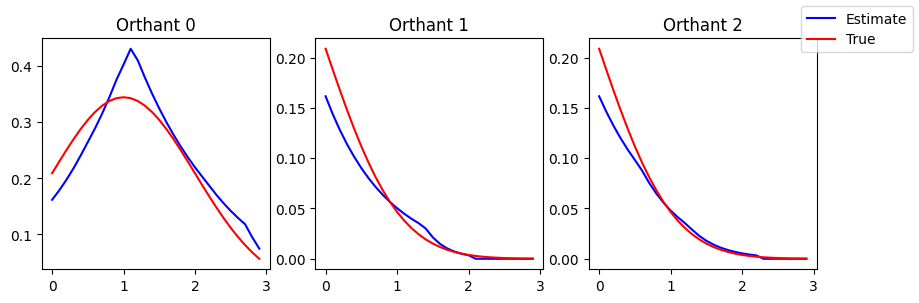

In [32]:
# plot of estimated density and true density
fig, axes = plt.subplots(1,3,figsize=(10,3))
xx = np.arange(0,3,0.1)
axes[0].plot(xx, np.vectorize(lcmle.pdf)(xx,0), c = "blue")
axes[0].plot(xx, np.vectorize(true_density.pdf)(xx,0), c = "red")
axes[0].set_title("Orthant 0")
axes[1].plot(xx, np.vectorize(lcmle.pdf)(xx,1), c = "blue")
axes[1].plot(xx, np.vectorize(true_density.pdf)(xx,1), c = "red")
axes[1].set_title("Orthant 1")
axes[2].plot(xx, np.vectorize(lcmle.pdf)(xx,2), c = "blue", label = "Estimate")
axes[2].plot(xx, np.vectorize(true_density.pdf)(xx,2), c = "red", label = "True")
axes[2].set_title("Orthant 2")
fig.legend()

## Kernel density estimator
To compare the result, we also compute the kernel density estimator from the same sample.

In [26]:
def cv_bandwidth_1dim(x, ort):
    pairwise_dist = 0
    dmat = lcd._kde._create_distance_mat_1dim(x, ort)
    dmat_l = np.tril(dmat, k=-1)
    mean_pairwise_dist = np.sum(dmat_l) / (dmat.shape[0] * (dmat.shape[0]-1)/2)
    pairwise_dist += mean_pairwise_dist
    pairwise_dist = pairwise_dist
    def loss(h):
        h = h[0]
        bw = h * pairwise_dist * pow(len(x), -1/5) # base.
        kde = lcd.kernel_density_estimate_1dim(x, ort, 3, bandwidth=bw)
        # first term
        term1a, _ = quad(lambda x: kde.pdf(x,0)**2, 0, np.inf, limit=100, epsabs=1e-4)
        term1b, _ = quad(lambda x: kde.pdf(x,1)**2, 0, np.inf, limit=100, epsabs=1e-4)
        term1c, _ = quad(lambda x: kde.pdf(x,2)**2, 0, np.inf, limit=100, epsabs=1e-4)
        term1 = term1a + term1b + term1c
        
        # second term
        term2 = 0
        for i in range(len(x)):
            indices = [True for j in range(len(x))]
            indices[i] = False
            kde_i = lcd.kernel_density_estimate_1dim(x[indices], ort[indices], 3, bandwidth=bw)
            term2 += kde_i.pdf(x[i], ort[i])
        term2 = term2 / len(x)
        
        return term1 -2 * term2
    res = minimize(loss, np.array([1]), bounds = [(0.1, 10)])
    return res.x[0]* pairwise_dist * pow(len(x), -1/5)


In [18]:
kde = lcd.kernel_density_estimate_1dim(x, ort, 3,nn_prop=0.2)
cv_bw = cv_bandwidth_1dim(x,ort)
kde2 = lcd.kernel_density_estimate_1dim(x, ort, 3, bandwidth=cv_bw)

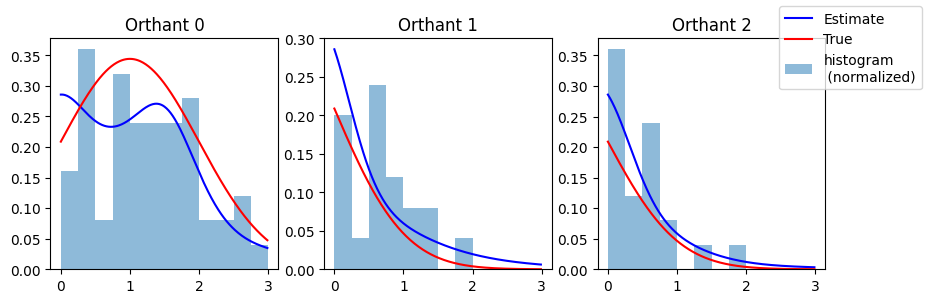

In [22]:
# plot of kernel density estimate and true_density
# Kernel density estimator
bin_edges = [k for k in np.arange(0,3.1,1/4)]
fig, axes = plt.subplots(1,3,figsize=(10,3))
xx = np.arange(0,3,0.01)
axes[0].plot(xx, np.vectorize(kde.pdf)(xx,0), c = "blue")
axes[0].plot(xx, np.vectorize(true_density.pdf)(xx,0), c = "red")
axes[0].hist(x[ort==0], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==0])) ] , alpha=0.5)
axes[0].set_title("Orthant 0")
axes[1].plot(xx, np.vectorize(kde.pdf)(xx,1), c = "blue")
axes[1].plot(xx, np.vectorize(true_density.pdf)(xx,1), c = "red")
axes[1].hist(x[ort==1], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==1])) ] , alpha=0.5)
axes[1].set_title("Orthant 1")
axes[2].plot(xx, np.vectorize(kde.pdf)(xx,2), c = "blue", label = "Estimate")
axes[2].plot(xx, np.vectorize(true_density.pdf)(xx,2), c = "red", label = "True")
axes[2].hist(x[ort==2], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==2])) ] , alpha=0.5, label="histogram\n (normalized)")
axes[2].set_title("Orthant 2")
fig.legend()

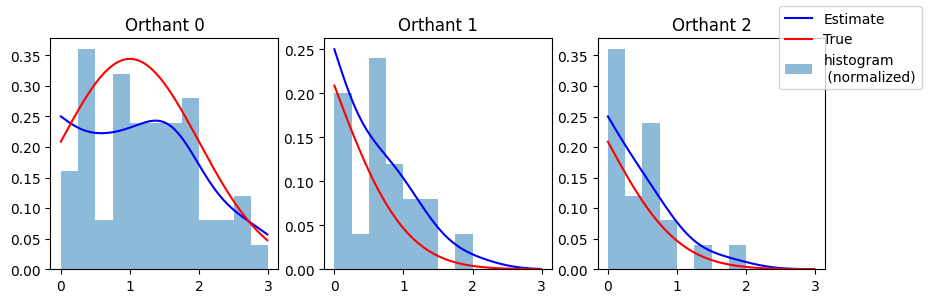

In [23]:
# plot of kernel density estimate and true_density
# Kernel density estimator
bin_edges = [k for k in np.arange(0,3.1,1/4)]
fig, axes = plt.subplots(1,3,figsize=(10,3))
xx = np.arange(0,3,0.01)
axes[0].plot(xx, np.vectorize(kde2.pdf)(xx,0), c = "blue")
axes[0].plot(xx, np.vectorize(true_density.pdf)(xx,0), c = "red")
axes[0].hist(x[ort==0], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==0])) ] , alpha=0.5)
axes[0].set_title("Orthant 0")
axes[1].plot(xx, np.vectorize(kde2.pdf)(xx,1), c = "blue")
axes[1].plot(xx, np.vectorize(true_density.pdf)(xx,1), c = "red")
axes[1].hist(x[ort==1], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==1])) ] , alpha=0.5)
axes[1].set_title("Orthant 1")
axes[2].plot(xx, np.vectorize(kde2.pdf)(xx,2), c = "blue", label = "Estimate")
axes[2].plot(xx, np.vectorize(true_density.pdf)(xx,2), c = "red", label = "True")
axes[2].hist(x[ort==2], bins = bin_edges, weights = [ 4/len(x)  for  _ in range(len(x[ort==2])) ] , alpha=0.5, label="histogram\n (normalized)")
axes[2].set_title("Orthant 2")
fig.legend()

## Computation of Integrated Squared Error (ISE)

In [15]:
# calculation of integrted squared error
#lcmle_ise, lcmle_err = lcd.ise_1dim(true_density, lcmle, epsabs = 1e-5)
kde_ise, kde_err = lcd.ise_1dim(true_density, kde, epsabs = 1e-5)

In [24]:
kde2_ise, kde_err = lcd.ise_1dim(true_density, kde2, epsabs = 1e-5)

In [25]:
kde_ise, kde2_ise

(0.014763694819420796, 0.01808077422856011)

In [38]:
lcmle_ise, kde_ise

(0.005594922534465946, 0.010364053493462963)

In [32]:
kde.Dmat[70][:5]

array([0.19700659, 0.19805876, 0.29868212, 0.38138158, 0.39340535])

In [33]:
x[:5], ort[:5]

(array([0.0754304 , 0.07648257, 0.17710593, 0.25980539, 0.27182916]),
 array([0, 0, 0, 0, 0]))

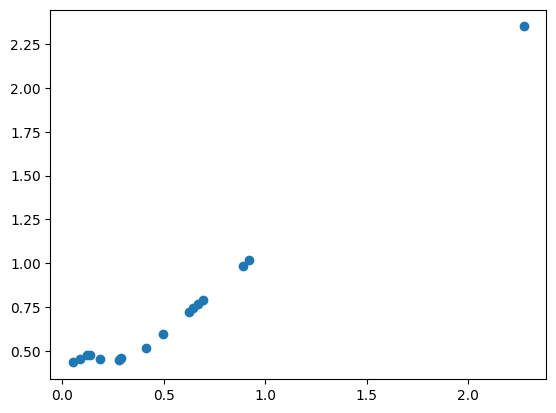

In [38]:
plt.scatter(x[ort==1], kde.bw[ort==1])